In [229]:
import optuna
from statsforecast import StatsForecast
from statsforecast.models import ARIMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utilsforecast.evaluation import evaluate

In [230]:
# Definir las métricas
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def evaluate(cv_df, metrics):
    results = {}
    for metric in metrics:
        y_true = cv_df['y'].values
        y_pred = cv_df['ARIMA'].values
        results[metric.__name__] = metric(y_true, y_pred)
    return results

In [231]:
import yfinance as yf

# Descargar datos
#tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
tickers = ['BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1mo')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)


[*********************100%%**********************]  1 of 1 completed

In [232]:
horizon = 1

In [234]:
# Definir función objetivo para Optuna
def objective(trial):
    # Definir el espacio de búsqueda de hiperparámetros
    order = (trial.suggest_int('p', 0, 3), 
             trial.suggest_int('d', 0, 2), 
             trial.suggest_int('q', 0, 3))
    seasonal_order = (trial.suggest_int('P', 0, 3), 
                      trial.suggest_int('D', 0, 2), 
                      trial.suggest_int('Q', 0, 3))
    season_length = trial.suggest_int('season_length', 1, 24)

    # Instanciar el modelo ARIMA con los parámetros
    model = ARIMA(order=order, 
                  seasonal_order=seasonal_order, 
                  season_length=season_length)
    
    # Instanciar StatsForecast
    sf = StatsForecast(df=Y_df, models=[model], freq='MS', n_jobs=-1)

    # Validación cruzada
    cv_df = sf.cross_validation(df=Y_df, h=horizon, step_size=horizon, n_windows=5)
    cv_df = cv_df.reset_index()
    
    # Evaluar las predicciones
    evaluation_results = evaluate(cv_df.loc[:, cv_df.columns != 'cutoff'], metrics=[smape, mape, mse, mae, rmse])
    
    print(evaluation_results)
    
    # Obtener SMAPE para la optimización
    smape_value = evaluation_results['smape']

    return smape_value 

# Configurar y ejecutar la optimización con Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

# Mostrar los mejores parámetros
best_params = study.best_params
print("Best parameters:", best_params)

{'smape': 9.495003521442413, 'mape': 9.569115936756134, 'mse': 46548360.0, 'mae': 5952.073, 'rmse': 6822.6357}
{'smape': 18.657858669757843, 'mape': 21.166567504405975, 'mse': 304288500.0, 'mae': 13127.019, 'rmse': 17443.867}
{'smape': 7.077188789844513, 'mape': 7.127867639064789, 'mse': 27286582.0, 'mae': 4454.671, 'rmse': 5223.656}
{'smape': 9.892048686742783, 'mape': 10.233619064092636, 'mse': 55254850.0, 'mae': 6401.8936, 'rmse': 7433.3604}
{'smape': 13.272839784622192, 'mape': 13.290154933929443, 'mse': 94693816.0, 'mae': 8275.865, 'rmse': 9731.075}
{'smape': 14.38240110874176, 'mape': 12.589982151985168, 'mse': 143427620.0, 'mae': 7881.225, 'rmse': 11976.127}
{'smape': 6.201229616999626, 'mape': 5.955232307314873, 'mse': 19327646.0, 'mae': 3727.6172, 'rmse': 4396.322}
{'smape': 10.133706033229828, 'mape': 10.329048335552216, 'mse': 45787076.0, 'mae': 6395.2017, 'rmse': 6766.6147}
{'smape': 10.192563384771347, 'mape': 10.617591440677643, 'mse': 53491770.0, 'mae': 6574.6733, 'rmse'

In [235]:
# Crear y ajustar el modelo final con los mejores parámetros
final_model = ARIMA(
    order=(best_params['p'], best_params['d'], best_params['q']),
    seasonal_order=(best_params['P'], best_params['D'], best_params['Q']),
    season_length=best_params['season_length']
)

# Instanciar StatsForecast con el modelo final
sf_final = StatsForecast(df=Y_df, models=[final_model], freq='MS', n_jobs=-1)

prediction_length = int(len(Y_df)) - horizon
Y_df_real = Y_df[:prediction_length]
Y_df_test = Y_df[prediction_length:]

sf_final.fit(Y_df_real)

# Realizar predicciones
forecast = sf_final.forecast(h=horizon)

# Mostrar las predicciones
print("Predictions:")
print(forecast)

Predictions:
                  ds         ARIMA
unique_id                         
Adj Close 2024-10-01  63609.550781


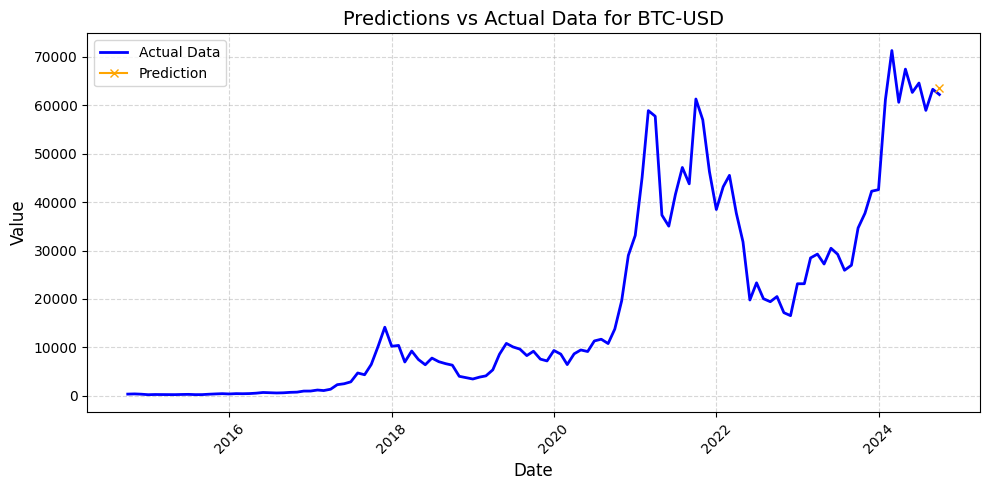

In [236]:
# Extract the actual and forecasted data
forecast_series = forecast[['ds', 'ARIMA']] 
real_series = Y_df[['ds', 'y']]  

plt.figure(figsize=(10, 5))

# Plot actual data as a solid line
plt.plot(real_series['ds'], real_series['y'], label='Actual Data', linestyle='-', color='blue', linewidth=2)

# Plot predictions as a dashed line
plt.plot(forecast_series['ds'], forecast_series['ARIMA'], label='Prediction', marker='x', color='orange')

# Configure the plot
plt.title(f'Predictions vs Actual Data for BTC-USD', fontsize=14)  
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(visible=True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()
